# 概要

- タスク：チャットボット
- モデル：LSTM を用いた seq2seq
- 学習データ：[コーネル映画会話コーパス](https://www.cs.cornell.edu/~cristian/Cornell_Movie-Dialogs_Corpus.html)（[参考](https://db-event.jpn.org/deim2016/papers/81.pdf)）

頭から実行していっても良いが、加工と学習にそこそこ時間がかかる。

学習済みの結果を使うには、下記のファイルが入った chatbot ディレクトリを GoogleDrive のルート直下に置く。
（Google Colab ではなくローカルで動かす場合は、任意の場所に置いて、以降のセルの絶対パスを適宜書き換える）
- `encoder_20epoch.pt`
- `decoder_20epoch.pt`
- `index2word_CornellMovie.pkl`
- `word2index_CornellMovie.pkl`

そうすると、全てのセルを実行する必要がなく、
下記のセクションだけ実行すればチャットボットを動かせる。
- 環境設定
- ライブラリのインポート
- Encoder, Decoder の定義
- モデル等の読み込み
- チャットボットの補助的な関数を定義
- チャットボットの関数を定義
- チャットボットを動かす


# 環境設定

In [2]:
# Google Colab をマウント
# 参考：https://qiita.com/k_uekado/items/45b76f9a6f920bf0f786

from google.colab import drive
drive.mount('/content/drive')

# 左サイドバーから確認できるように、
# GoogleDrive のルートが colab の drive/My Drive/ にマウントされてる。
# ローカルで動かす場合は実行しなくて良い。

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
# GPU 設定
# 参考：https://qiita.com/tomo_makes/items/f70fe48c428d3a61e131
# ランタイム -> ランタイムのタイプ変更 -> ハードウェアアクセラレータに GPU

import torch

print(torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

True


# ライブラリのインポート

In [6]:
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import csv
import random
import re
import os
import unicodedata
import codecs
import itertools
import matplotlib.pyplot as plt
import time
import pickle

# コーネル映画対話データの前処理

In [ ]:
# 見てみる

corpus_name = "cornell movie-dialogs corpus"
corpus = "/content/drive/My Drive/chatbot/data/" + corpus_name

def printLines(file, n=10):
    """ 表示用関数
    file の n 行目までを出力する。
    """
    with open(file, 'rb') as datafile:
        lines = datafile.readlines()
    for line in lines[:n]:
        print(line)

printLines(os.path.join(corpus, "movie_lines.txt"), n=5)
printLines(os.path.join(corpus, "movie_conversations.txt"), n=5)
# フォーマットの詳細はダウンロード元の
# https://www.cs.cornell.edu/~cristian/Cornell_Movie-Dialogs_Corpus.html
# を参照。

b'L1045 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ They do not!\n'
b'L1044 +++$+++ u2 +++$+++ m0 +++$+++ CAMERON +++$+++ They do to!\n'
b'L985 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ I hope so.\n'
b'L984 +++$+++ u2 +++$+++ m0 +++$+++ CAMERON +++$+++ She okay?\n'
b"L925 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ Let's go.\n"
b"u0 +++$+++ u2 +++$+++ m0 +++$+++ ['L194', 'L195', 'L196', 'L197']\n"
b"u0 +++$+++ u2 +++$+++ m0 +++$+++ ['L198', 'L199']\n"
b"u0 +++$+++ u2 +++$+++ m0 +++$+++ ['L200', 'L201', 'L202', 'L203']\n"
b"u0 +++$+++ u2 +++$+++ m0 +++$+++ ['L204', 'L205', 'L206']\n"
b"u0 +++$+++ u2 +++$+++ m0 +++$+++ ['L207', 'L208']\n"


## 前処理その１（フォーマットまわり）

In [ ]:
# 加工用の関数の定義１（フォーマットまわり）


def loadLines(fileName, fields):
    """ 各行の文ををカラムに分割
    fileName の各行を、fields に指定されたフィールド (カラム) に分割。
    結果を dict で返す。
    """
    lines = {}
    with open(fileName, 'r', encoding='iso-8859-1') as f:
        for line in f:
            values = line.split(" +++$+++ ")
            # Extract fields
            lineObj = {}
            for i, field in enumerate(fields):
                lineObj[field] = values[i]
            lines[lineObj['lineID']] = lineObj
    return lines


def loadConversations(fileName, lines, fields):
    """ loadLines で得られた各行を movie_conversations.txt に基づく会話へグループ分け。
    loadLines で１セリフを１メンバとした dict を作った。
    ここに対話情報を合わせて「１対話ごとに１要素のリスト」を作る。
    誰と誰が対話してて、みたいな。
    """
    conversations = []
    with open(fileName, 'r', encoding='iso-8859-1') as f:
        for line in f:
            values = line.split(" +++$+++ ")
            # Extract fields
            convObj = {}
            for i, field in enumerate(fields):
                convObj[field] = values[i]
            # Convert string to list (convObj["utteranceIDs"] == "['L598485', 'L598486', ...]")
            utterance_id_pattern = re.compile('L[0-9]+')
            lineIds = utterance_id_pattern.findall(convObj["utteranceIDs"])
            # Reassemble lines
            convObj["lines"] = []
            for lineId in lineIds:
                convObj["lines"].append(lines[lineId])
            conversations.append(convObj)
    return conversations


def extractSentencePairs(conversations):
    """
    送信と返信を分けるってのをやってる。
    """
    qa_pairs = []
    for conversation in conversations:
        # Iterate over all the lines of the conversation
        for i in range(len(conversation["lines"]) - 1):  # We ignore the last line (no answer for it)
            inputLine = conversation["lines"][i]["text"].strip()
            targetLine = conversation["lines"][i+1]["text"].strip()
            # Filter wrong samples (if one of the lists is empty)
            if inputLine and targetLine:
                qa_pairs.append([inputLine, targetLine])
    return qa_pairs



In [ ]:
# 加工の実行１


# 加工後のデータをこのファイルに書き込む
datafile = "/content/drive/My Drive/chatbot/data/" + "formatted_movie_lines.txt"

# 送信返信の区切り文字としてタブ'\t'を使用。
delimiter = '\t'
# '\t' をエスケープ文字として扱わせない
delimiter = str(codecs.decode(delimiter, "unicode_escape"))


lines = {}
conversations = []
# 完成形テーブル2つのフィールド(カラム)名をセット。
MOVIE_LINES_FIELDS = ["lineID", "characterID", "movieID", "character", "text"]
MOVIE_CONVERSATIONS_FIELDS = ["character1ID", "character2ID", "movieID", "utteranceIDs"]


# プレーンテキストの各行を MOVIE_LINES_FIELDS に指定したフィールド(カラム)に分割。
print("\nProcessing corpus...")
lines = loadLines(os.path.join(corpus, "movie_lines.txt"), MOVIE_LINES_FIELDS)

# 上記の lines は「１セリフ１メンバの dict」だが、これを「１対話１要素のリスト」にする。
print("\nLoading conversations...")
conversations = loadConversations(os.path.join(corpus, "movie_conversations.txt"),
                                  lines, MOVIE_CONVERSATIONS_FIELDS)


# ファイル書き込み（初回のみ実行）
# 上記で得られた結果を、さっき指定した datafile == "formatted_movie_lines.txt" に書き込む。
# この時に、送信と返信をタブ区切りにしている。
print("\nWriting newly formatted file...")
with open(datafile, 'w', encoding='utf-8') as outputfile:
    writer = csv.writer(outputfile, delimiter=delimiter, lineterminator='\n')
    for pair in extractSentencePairs(conversations):
        writer.writerow(pair)


# 見てみる
print("\nSample lines from file:")
printLines(datafile, n=5)
# 出力ファイル "formatted_movie_lines.txt" を開いて見ると良い。
# 221282 行ある。送信返信の対がこれだけあるってこと。
# \t で送信と返信がタブ区切りされていることに注目。



Processing corpus...

Loading conversations...

Writing newly formatted file...

Sample lines from file:
b"Can we make this quick?  Roxanne Korrine and Andrew Barrett are having an incredibly horrendous public break- up on the quad.  Again.\tWell, I thought we'd start with pronunciation, if that's okay with you.\n"
b"Well, I thought we'd start with pronunciation, if that's okay with you.\tNot the hacking and gagging and spitting part.  Please.\n"
b"Not the hacking and gagging and spitting part.  Please.\tOkay... then how 'bout we try out some French cuisine.  Saturday?  Night?\n"
b"You're asking me out.  That's so cute. What's your name again?\tForget it.\n"
b"No, no, it's my fault -- we didn't have a proper introduction ---\tCameron.\n"


formatted_movie_lines.txt の l.211716〜。

タブ\tで分割し、対になってるのを重複消し、並べてみた。

こういう自然な対話が入っているデータ。どの映画かの情報は消したが。

Can I help you, sir?

I need a ticket.

Where to?

Out of here.

But, in particular?

I . . . Mexico.  You got a bus that goes to Mexico?  That's where I have to go.

Where in Mexico would you like--

I don't care, just get me there.

We have a bus to Mexico.  Arrives in two hours.  Have to make a couple of connections, but it will get you across the border.

How much.

One way, or round trip?

One way.

Thirty even.

Twenty-seven fifty.  That's all I got.	

The ticket is thirty dollars.

I bought a beer.  That was two- fifty. I bought a beer, otherwise I would have thirty.

I'm sorry, sir.  It's thirty dollars for the ticket.

Yeah.  Just a little short. Figures.  I just wanted to get out, that's all. Please, you don't understand.  I have to get out of here.  They're going to come looking for me. They're going to kill me.  If I can't get this ticket then I'm going to have to do things to get out of here.  I don't want to hurt anybody, I just want to leave.

I'll give you the money!  Okay? I'll give you two-fifty.

## 前処理その２（辞書まわり）

In [ ]:
# 加工用の定義２（辞書まわり）


PAD_token = 0  # Used for padding short sentences
# パディング(短すぎる文の後ろを穴埋め)用

SOS_token = 1  # Start-of-sentence token
# 文頭を表す文字的

EOS_token = 2  # End-of-sentence token
# 文末を表す文字的


class Voc:
    """単語の辞書＝Vocabulary
    Attributes
      trimmed: すでに trim() メソッドが実行されたか。
      word2index：単語をIDに変換する dict
      word2count：単語を出現回数に変換する dict
      index2word：IDを単語に変換する dict
    """
    def __init__(self, name):
        self.name = name
        self.trimmed = False
        self.word2index = {}
        self.word2count = {}
        self.index2word = {PAD_token: "PAD", SOS_token: "SOS", EOS_token: "EOS"}
        self.num_words = 3  # Count SOS, EOS, PAD

    def addSentence(self, sentence):
        """
        文を半スペで分割して単語にして、そのすべての単語に addWord() を適用。
        """
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        """
        単語を辞書つまり語彙に追加する。
        ついでに出現回数もカウントしている。
        """
        if word not in self.word2index:
            self.word2index[word] = self.num_words
            self.word2count[word] = 1
            self.index2word[self.num_words] = word
            self.num_words += 1
        else:
            self.word2count[word] += 1

    # Remove words below a certain count threshold
    def trim(self, min_count):
        """
        稀な(出現回数の少ない)単語をトリムする、つまり除去する。
        """
        if self.trimmed:
            return
        self.trimmed = True

        keep_words = []

        for k, v in self.word2count.items():
            if v >= min_count:
                keep_words.append(k)

        print('keep_words {} / {} = {:.4f}'.format(
            len(keep_words), len(self.word2index), len(keep_words) / len(self.word2index)
        ))

        # Reinitialize dictionaries
        self.word2index = {}
        self.word2count = {}
        self.index2word = {PAD_token: "PAD", SOS_token: "SOS", EOS_token: "EOS"}
        self.num_words = 3 # Count default tokens

        for word in keep_words:
            self.addWord(word)


MAX_LENGTH = 10  # Maximum sentence length to consider
# 質問/返答 ともに 10 word 以下の対話の対を、扱う。
# それ以外はフィルタかけて取り除いてしまう。まあ後でこのグローバル設定値を使う。
# 長期依存性の学習を十分に行えるモデルなら、ここを大きくしても問題ない。


# Unicode 文字列を ASCII に変換
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )


# Lowercase, trim, and remove non-letter characters
# 上記の unicodeToASCII() を呼んで ASCII にした上で、
# すべての文字を小文字に変換し、句読点を除去し、アルファベット以外の文字を除去。
# 正規表現で頑張っている。
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    s = re.sub(r"\s+", r" ", s).strip()
    return s


# Read query/response pairs and return a voc object
# 質問/応答 の対を読み込んで上記関数で正規化した上で返却。
# その際にタブ\tで 質問/応答 を分割して、(質問,応答) というタプルでペアにする。
# また、辞書 Voc インスタンスを生成して返却。
def readVocs(datafile, corpus_name):
    print("Reading lines...")
    # Read the file and split into lines
    lines = open(datafile, encoding='utf-8').\
        read().strip().split('\n')
    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]
    voc = Voc(corpus_name)
    return voc, pairs


# グローバルで指定した閾値 MAX_LENGTH より短い文からなる対話(対)かどうかを判定する。
# 質問/応答 ともに MAX_LENGTH より短かったら、True を返す。
def filterPair(p):
    # Input sequences need to preserve the last word for EOS token
    return len(p[0].split(' ')) < MAX_LENGTH and len(p[1].split(' ')) < MAX_LENGTH


# Filter pairs using filterPair condition
# 複数の 質問/応答 に上記フィルターを適用して、一気に判定。
def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]


# 上記で定義した様々な関数を一気に実行する関数。(アプリケーションサービス）
def loadPrepareData(corpus, corpus_name, datafile):
    print("Start preparing training data ...")
    voc, pairs = readVocs(datafile, corpus_name)
    print("Read {!s} sentence pairs".format(len(pairs)))
    pairs = filterPairs(pairs)
    print("Trimmed to {!s} sentence pairs".format(len(pairs)))
    print("Counting words...")
    for pair in pairs:
        voc.addSentence(pair[0])
        voc.addSentence(pair[1])
    print("Counted words:", voc.num_words)
    return voc, pairs


# レア単語判定の閾値。すぐ後ろで使う。
MIN_COUNT = 3    # Minimum word count threshold for trimming

def trimRareWords(voc, pairs, MIN_COUNT):
    # Trim words used under the MIN_COUNT from the voc
    """
    出現回数が MIN_COUNT より小さいレアな単語を、辞書から削除する。
    さらに、会話ペアのうち「質問にも応答にもレア単語が含まれていない」ものだけ残し、あとは除去する。
    """
    voc.trim(MIN_COUNT)
    # Filter out pairs with trimmed words
    keep_pairs = []
    for pair in pairs:
        input_sentence = pair[0]
        output_sentence = pair[1]
        keep_input = True
        keep_output = True
        # Check input sentence
        for word in input_sentence.split(' '):
            if word not in voc.word2index:
                keep_input = False
                break
        # Check output sentence
        for word in output_sentence.split(' '):
            if word not in voc.word2index:
                keep_output = False
                break

        # Only keep pairs that do not contain trimmed word(s) in their input or output sentence
        if keep_input and keep_output:
            keep_pairs.append(pair)

    print("Trimmed from {} pairs to {}, {:.4f} of total".format(len(pairs), len(keep_pairs), len(keep_pairs) / len(pairs)))
    return keep_pairs


In [ ]:
# 加工の実行２


# 上の loadPrepareData() を実行して、辞書(vocabulary)と質問応答ペアを取得。
voc, pairs = loadPrepareData(corpus, corpus_name, datafile)

print({k:voc.index2word[k] for k in list(voc.index2word)[:10]})
print({k:voc.word2count[k] for k in list(voc.word2count)[:10]})

for pair in pairs[40:50]:
    print(pair)


# レアな単語の除去を実行
pairs = trimRareWords(voc, pairs, MIN_COUNT)  # voc は内部状態が更新される。
# print の通り、20%の会話を削るだけで、50%以上の単語を削ることができている。


Start preparing training data ...
Reading lines...
Read 221282 sentence pairs
Trimmed to 64271 sentence pairs
Counting words...
Counted words: 18008
{0: 'PAD', 1: 'SOS', 2: 'EOS', 3: 'there', 4: '.', 5: 'where', 6: '?', 7: 'you', 8: 'have', 9: 'my'}
{'there': 2013, '.': 104124, 'where': 2475, '?': 43942, 'you': 29248, 'have': 3023, 'my': 3148, 'word': 125, 'as': 558, 'a': 8579}
['how many people were in your old school ?', 'thirty two .']
['thirty two .', 'get out !']
['get out !', 'how many people go here ?']
['how many people go here ?', 'couple thousand . most of them evil']
['that girl i', 'you burn you pine you perish ?']
['you burn you pine you perish ?', 'who is she ?']
['yeah just a minor encounter with the shrew .', 'that s her ? bianca s sister ?']
['that s her ? bianca s sister ?', 'the mewling rampalian wretch herself .']
['what about him ?', 'you wanna go out with him ?']
['what makes you think he ll do it ?', 'he seems like he thrives on danger']
keep_words 7823 / 18005 =

## 前処理その３（torch.Tensor化まわり）

In [ ]:
# 加工用の定義３（torch.Tensor化まわり）


def indexesFromSentence(voc, sentence):
    return [voc.word2index[word] for word in sentence.split(' ')] + [EOS_token]


def zeroPadding(l, fillvalue=PAD_token):
    return list(itertools.zip_longest(*l, fillvalue=fillvalue))


def binaryMatrix(l, value=PAD_token):
    m = []
    for i, seq in enumerate(l):
        m.append([])
        for token in seq:
            if token == PAD_token:
                m[i].append(0)
            else:
                m[i].append(1)
    return m


def inputVar(l, voc):
    indexes_batch = [indexesFromSentence(voc, sentence) for sentence in l]
    lengths = torch.tensor([len(indexes) for indexes in indexes_batch])
    padList = zeroPadding(indexes_batch)
    padVar = torch.LongTensor(padList).to(device)  # GPU指定
    return padVar, lengths


def outputVar(l, voc):
    indexes_batch = [indexesFromSentence(voc, sentence) for sentence in l]
    max_target_len = max([len(indexes) for indexes in indexes_batch])
    padList = zeroPadding(indexes_batch)
    mask = binaryMatrix(padList)
    mask = torch.BoolTensor(mask)
    padVar = torch.LongTensor(padList).to(device)  # GPU指定
    return padVar, mask, max_target_len


def batch2TrainData(voc, pair_batch):
    pair_batch.sort(key=lambda x: len(x[0].split(" ")), reverse=True)
    input_batch, output_batch = [], []
    for pair in pair_batch:
        input_batch.append(pair[0])
        output_batch.append(pair[1])
    inp, lengths = inputVar(input_batch, voc)
    output, mask, max_target_len = outputVar(output_batch, voc)
    return inp, lengths, output, mask, max_target_len


In [ ]:
# 一部加工してみる
# 学習の際は、ミニバッチサンプリングの後に毎回、batch2TrainData() を呼び出して使う。


small_batch_size = 5     # とりあえず 5 つの会話について加工前後を見る。

# 加工本体
tmp = [random.choice(pairs) for _ in range(small_batch_size)]
batches = batch2TrainData(voc, tmp)
print(tmp)  # small_batch_size分の会話ペア。

# 返却値のタプルを分ける
input_variable, lengths, target_variable, mask, max_target_len = batches

print("input_variable:\n", input_variable.T)
input_variable.T.shape
input_variable.T[1]
# 元の会話バッチ tmp の質問文の方を ID 化したもの。
# MAX_LENGTH = 10 で 質問/返答 ともに 10 word 以下の対話の対を扱い、
# かつ、ゼロパディングするので、
# 横のサイズが 10 以下(バッチ内の最長にものに合わさるようになってる)になっている。
# 縦のサイズはもちろん質問文の数つまり会話バッチサイズ。
# <EOS> の ID が 2 ってことにも注意。


# print("target_variable:", target_variable)
print("target_variable:\n", target_variable.T)
target_variable.T.shape
# input_variable の応答文バージョン。モデル的にはターゲット(アウトカム)



[['your mom take anything before this happened ?', 'yeah but i don t know what .'], ['that requires me goin out tonight ?', 'a bit .'], ['certainly . right over there .', 'you re all right .'], ['come on .', 'no . no no no .'], ['maybe .', 'don t you care ?']]
input_variable:
 tensor([[  70, 1119,  218,  371,  129,   45,  368,    6,    2],
        [  36, 4458,   83,  212,   21,   22,    6,    2,    0],
        [2387,    4,  266,  935,    3,    4,    2,    0,    0],
        [ 401,  177,    4,    2,    0,    0,    0,    0,    0],
        [ 287,    4,    2,    0,    0,    0,    0,    0,    0]],
       device='cuda:0')
target_variable:
 tensor([[ 167,   42,   25,  197,  117,   24,   50,    4,    2],
        [  12, 1947,    4,    2,    0,    0,    0,    0,    0],
        [   7,   14,   38,  266,    4,    2,    0,    0,    0],
        [  34,    4,   34,   34,   34,    4,    2,    0,    0],
        [ 197,  117,    7,  280,    6,    2,    0,    0,    0]],
       device='cuda:0')


torch.Size([5, 9])

# Encoder, Decoder の定義

In [7]:

class Encoder(nn.Module):
    """ Encoder in seq2seq
    
    質問文を処理する Encoder で、系列データを文脈ベクトルに変換する。
    
    LSTM を使っているが、GRU や Elman RNN でも OK。
    ここを他のものに変えて比較等できれば良いと思う(が、計算時間、、、)

    最終 LSTM ユニットの状態 h と記憶 c を合わせたものを文脈ベクトルとし、decoder に引き継ぐ。 
    
    nn.LSTM クラスについては、公式ドキュメント
    https://pytorch.org/docs/master/generated/torch.nn.LSTM.html
    が分かりやすい。

    backward()は「PyTorch用データ型 torch.Tensor 自体」に実装されている。
    
    Attributes:
      hidden_dim：コンストラクタ参照。
      word_embeddings： embedding レイヤ。系列の数だけまとめたもの。
      lstm： LSTM レイヤ。系列の数だけまとまってる。
    
    """
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        """ initialization
        Args:
          vocab_size：語彙数。つまり embedding レイヤの入力の次元。
          embedding_dim：単語を埋め込む次元。embedding レイヤの出力の次元。
          hidden_dim：状態hの次元＝記憶cの次元。モデル式の通り LSTM では同じ。
        """
        super(Encoder, self).__init__()
        self.hidden_dim = hidden_dim
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        # padding_idx=0 はパディング文字の ID は 0 にしてあります、という意味。
        # 効果は https://takoroy-ai.hatenadiary.jp/entry/2018/07/02/224216
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        # batch_first=True としておくと、forward の入出力のテンソルの形状が、
        # (batch, seq, feature) つまり (文数, 単語数, 次元数) になる。

    def forward(self, sequence):
        """ forward propagation
        入力系列 -> 文脈ベクトル(最終ユニットの状態と記憶)
        nn.Module を継承してるので Encoder インスタンスを関数ぽく呼んだ時に、
        この forward が呼び出され実行される。明示しても良いが。
        Args:
          sequence：質問文のバッチ。ID化されて int になってる状態。
        """
        # 前述の仕組みで embedding の forward つまり単語埋め込みが実行されてる。
        embedding = self.word_embeddings(sequence)
        # 後述の通り「最終LSTMユニットの状態+記憶」は 2 番目の返却値。これが encoder の出力つまり文脈ベクトル。
        _, state = self.lstm(embedding)
        return state


In [9]:

class Decoder(nn.Module):
    """ Decoder in seq2seq

    回答文を生成する Decoder で、文脈ベクトルを系列データに変換する。
    LSTM を使っているが、GRU や Elman RNN でも OK。
    初期時点の状態と記憶に、文脈ベクトル(Encoder の最終 LSTM ユニットの状態 h と記憶 c)を使っている。
    
    nn.Linear クラスについては、公式ドキュメント
    https://pytorch.org/docs/master/generated/torch.nn.Linear.html
    が分かりやすい。

    backward()は「PyTorch用データ型 torch.Tensor 自体」に実装されている。
    
    softmax は Decoder には入れない。ロス のとこに入れる。
    
    Attributes:
      hidden_dim：コンストラクタ参照。
      word_embeddings： embedding レイヤ。複数系列分。
      lstm： LSTM レイヤ。複数系列分のユニットのかたまり。
      hidden2linear：線形(Affine)変換レイヤ。隠れ状態をAffine変換して単語出現スコアにしてる。
    
    """
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        """
        Args:
          vocab_size：語彙数。つまり Linear(Affine) レイヤの出力の次元。
          embedding_dim：単語を埋め込む次元。embedding レイヤの出力の次元。
          hidden_dim：状態hの次元＝記憶cの次元。モデル式の通り LSTM では同じ。
        今回は、Encoder と Decoder で別ルールで埋め込みする。
        なので、embedding_dim については Encoder の方と一致している必要はない。
        hidden_dim は一致していないとダメ。文脈を引き継げない。
        """
        super(Decoder, self).__init__()
        self.hidden_dim = hidden_dim
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        # padding_idx=0 はパディング文字の ID は 0 にしてあります、という意味。
        # 効果は https://takoroy-ai.hatenadiary.jp/entry/2018/07/02/224216
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        # batch_first=True としておくと、forward の入出力のテンソルの形状が、
        # (batch, seq, feature) つまり (文数, 単語数, 次元数) になる。
        self.hidden2linear = nn.Linear(hidden_dim, vocab_size)

    def forward(self, sequence, encoder_state):
        """ forward propagation
        文脈ベクトル(Encoder最終ユニットの状態と記憶) -> 出力系列
        nn.Module を継承してるので Encoder インスタンスを関数ぽく呼んだ時に、
        この forward が呼び出され実行される。明示しても良いが。
        Args:
          sequence: 教師強制学習の際は応答文のバッチ。予測(推論)の際は1つ前で生成された単語？
        """
        embedding = self.word_embeddings(sequence)
        # 前述の通り、第1返却値が「全時点ユニットにおける隠れ状態」なので、教師強制学習の時はこれそのまま使える。
        # また、第2返却値は「最終ユニットの隠れ状態+記憶」で、予測(推論)の際は文を作り続けるので必要。
        output, state = self.lstm(embedding, encoder_state)
        output = self.hidden2linear(output)
        return output, state


# モデルの作成・ハイパーパラメータ的要素の設定

In [ ]:

# モデルのハイパーパラメータ設定と作成

word_embedding_dim = 500  # 単語を埋め込む次元。encoder と decoder で共有しよう。
state_memory_dim = 500    # 状態・記憶の次元

encoder = Encoder(
    vocab_size=len(voc.index2word),
    embedding_dim= word_embedding_dim,
    hidden_dim=state_memory_dim
).to(device)  # GPU指定

decoder = Decoder(
    vocab_size=len(voc.index2word),
    embedding_dim=word_embedding_dim,
    hidden_dim=state_memory_dim
).to(device)  # GPU指定


# 学習の設定 (ハイパーパラメータとみなせる)

criterion = nn.CrossEntropyLoss()  # ロス指標
# CrossEntropyLoss には softmax 変換も入っている。

encoder_optimizer = optim.Adam(encoder.parameters(), lr=0.001)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=0.001)
# とりあえず Adam を使っておく。

batch_size = 64
iter_per_epoch = int(len(pairs) / batch_size)
epoch_num = 20
# iter_per_epoch = 10
# epoch_num = 10


# 学習の実行

training ...
Epoch 1: 19346.14
Epoch 2: 16044.28
Epoch 3: 14326.04
Epoch 4: 12844.57
Epoch 5: 11458.40
Epoch 6: 10157.52
Epoch 7: 8957.80
Epoch 8: 7902.11
Epoch 9: 6922.49
Epoch 10: 6060.21
Epoch 11: 5343.09
Epoch 12: 4711.15
Epoch 13: 4159.06
Epoch 14: 3689.56
Epoch 15: 3286.21
Epoch 16: 2962.84
Epoch 17: 2683.89
Epoch 18: 2478.16
Epoch 19: 2262.94
Epoch 20: 2104.73


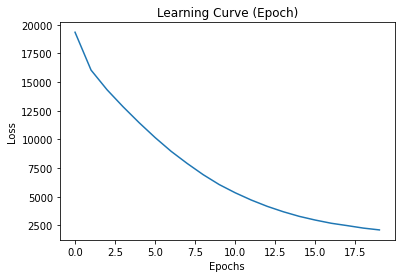

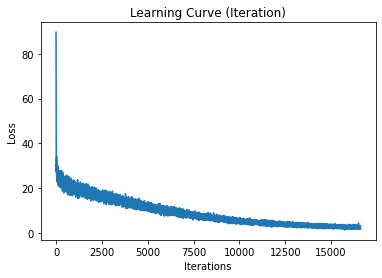

Done
経過時間：242.40701818466187


In [ ]:
start = time.time()

all_epoch_losses = []
all_iter_losses = []

print("training ...")


# epoch = 0
for epoch in range(epoch_num):
    
    epoch_loss = 0 # epoch毎のloss

    # i = 0
    for i in range(iter_per_epoch):

        # 勾配の初期化
        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        # データをテンソルに変換
        input_ts, _, output_ts, __, ___ = batch2TrainData(
            voc, [random.choice(pairs) for _ in range(batch_size)]
        )
        input_ts = input_ts.T # これでOK。EOSがあるままで良いと思う。貴重な情報。
        output_ts = output_ts.T
        sos = torch.ones(output_ts.shape[0], 1, dtype=int, device=device)  # GPU指定
        output_ts = torch.cat((sos, output_ts), 1)  # SOS_token 1 を先頭にくっつければ良さそう。

        # Encoderの順伝搬
        encoder_state = encoder(input_ts)

        # Decoderに教師強制で入力する文。次の単語は？のモデルなので最後の単語は使わない。
        source = output_ts[:, :-1]

        # Decoderの教師データ。次の単語は？のモデルなので SOS token 1 を削る。
        target = output_ts[:, 1:]

        loss = 0
        # 学習時はDecoderはこのように１回呼び出すだけでグルっと系列をループしているからこれでOK
        decoder_output, _ = decoder(source, encoder_state)

        for j in range(decoder_output.size()[1]):
            # バッチ毎にまとめてloss計算
            loss += criterion(decoder_output[:, j, :], target[:, j])

        epoch_loss += loss.item()
        all_iter_losses.append(loss.item())

        # 誤差逆伝播
        loss.backward()  # これでいける。
        # loss には criterion の返却値がスタックされていて、
        # criterion には decoder の output が渡されていて、
        # decoder の output が得られるまでの演算過程が内部で保存されているので、
        # loss.backward() を引金に一気に back prop される。

        # パラメータ更新
        # Encoder、Decoder両方学習
        encoder_optimizer.step()
        decoder_optimizer.step()  # これでいける。
        # 両 optimizer インスタンス生成時にすでにパラメータオブジェクトへのパスが通っていて、
        # パラメータオブジェクト自体に勾配が記録されているので、これで OK。

    # 損失を表示
    print("Epoch %d: %.2f" % (epoch+1, epoch_loss))
    all_epoch_losses.append(epoch_loss)
    if epoch_loss < 1: break

plt.plot(all_epoch_losses)
plt.title("Learning Curve (Epoch)")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()
# fig = plt.figure()
plt.plot(all_iter_losses)
plt.title("Learning Curve (Iteration)")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.show()
# fig.savefig("learning_curve_seq2seq.png")

print("Done")

elapsed_time = time.time() - start
print(f"経過時間：{elapsed_time}")

# 計算の量 : ローカル CPU : Colab GPU
# 100iters : ２分         : ２秒
# 5epochs  : １時間       : １分
# 20epochs :  ー          : ４分    

# 学習したモデル等の保存

In [ ]:

# モデルの保存
# torch.save(encoder.state_dict(), "/content/drive/My Drive/chatbot/encoder_20epoch.pt")
# torch.save(decoder.state_dict(), "/content/drive/My Drive/chatbot/decoder_20epoch.pt")
# マウントされてる場所にちゃんと保存する。

# 辞書も保存しておく
# with open("/content/drive/My Drive/chatbot/word2index_CornellMovie.pkl", "wb") as f:
#     pickle.dump(voc.word2index, f) #保存
# with open("/content/drive/My Drive/chatbot/index2word_CornellMovie.pkl", "wb") as f:
#     pickle.dump(voc.index2word, f) #保存


# モデル等の読み込み

- 上記セルで学習したモデルをそのまま使う
- or 以前に学習済みのモデルを使う

辞書についてもどちらか。

In [10]:

# 上記セルで学習したモデルをそのまま使う場合
# encoder_loaded = encoder
# decoder_loaded = decoder

# 以前に学習済みのモデルを使う場合
encoder_loaded = Encoder(vocab_size=7826, embedding_dim=500, hidden_dim=500).to(device)  # GPU
decoder_loaded = Decoder(vocab_size=7826, embedding_dim=500, hidden_dim=500).to(device)  # GPU
# encoder_loaded.load_state_dict(torch.load("/content/drive/My Drive/chatbot/encoder_20epoch.pt"))
# decoder_loaded.load_state_dict(torch.load("/content/drive/My Drive/chatbot/decoder_20epoch.pt"))
encoder_loaded.load_state_dict(torch.load("/content/chatbot/encoder_20epoch.pt"))
decoder_loaded.load_state_dict(torch.load("/content/chatbot/decoder_20epoch.pt"))


# 上記で作った辞書をそのまま使う
# index2word = voc.index2word
# word2index = voc.word2index

# 前に作った辞書を読み込む
# with open("/content/drive/My Drive/chatbot/index2word_CornellMovie.pkl", "rb") as f:
#     index2word = pickle.load(f)
# with open("/content/drive/My Drive/chatbot/word2index_CornellMovie.pkl", "rb") as f:
#     word2index = pickle.load(f)
with open("/content/chatbot/index2word_CornellMovie.pkl", "rb") as f:
    index2word = pickle.load(f)
with open("/content/chatbot/word2index_CornellMovie.pkl", "rb") as f:
    word2index = pickle.load(f)


# チャットボットの補助的な関数を定義

In [11]:

# Unicode 文字列を ASCII に変換
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )


# Lowercase, trim, and remove non-letter characters
# 上記の unicodeToASCII() を呼んで ASCII にした上で、
# すべての文字を小文字に変換し、句読点を除去し、アルファベット以外の文字を除去。
# 正規表現で頑張っている。
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    s = re.sub(r"\s+", r" ", s).strip()
    return s


def get_max_index(decoder_output):
    results = []
    for h in decoder_output:
        results.append(torch.argmax(h))
    return torch.tensor(results, device=device).view(1, 1)  # GPU指定


# チャットボットの関数を定義

In [12]:

def chatbot(user_question, encoder_model=encoder_loaded, decoder_model=decoder_loaded, word2index=word2index, index2word=index2word, SOS_token=1, EOS_token=2):
    """ chatbot by seq2seq
    """
    user_input = normalizeString(user_question)
    user_input = [word2index[word] for word in user_input.split(' ')] + [EOS_token]
    user_input = torch.LongTensor([user_input]).to(device)  # GPU指定

    with torch.no_grad():
        
        encoder_state = encoder_model(user_input)
        
        # Decoderにはまず文字列生成開始を表す"SOS"をインプットにする
        decoder_input_tensor = torch.tensor([[SOS_token]]).to(device)  # GPU指定
        
        # 文脈ベクトルを enc から dec へ
        decoder_hidden = encoder_state
        
        # 結果(単語)を結合するための入れ物を定義
        batch_tmp = torch.zeros(1,1, dtype=torch.long).to(device)  # GPU指定
        
        while decoder_input_tensor[0][0] != EOS_token:  # EOS が出るまで単語生成
            decoder_output, decoder_hidden = decoder_model(decoder_input_tensor, decoder_hidden)
            decoder_output.shape     # 予測された文字出現スコア
            decoder_hidden[0].shape  # 次時点の(状態,記憶)のタプル
            decoder_input_tensor = get_max_index(decoder_output[0])
            batch_tmp = torch.cat([batch_tmp, decoder_input_tensor], dim=1)
            
        # 最初のbatch_tmpの0要素が先頭に残ってしまっているのでスライスして削除
        bot_output = batch_tmp[:,1:][0]

    bot_output = [index2word[int(idx)] for idx in bot_output]
    bot_answer = " ".join(bot_output[:-1])

    return bot_answer


 # チャットボットを動かす

In [14]:
# チャットボットを実行。 exit と打つと終了する。
# 「未知の単語」トークンを辞書に追加するのを忘れたので、辞書に無い語を打つとエラーになる...

while True:
    q = input("You : ")
    if q == "exit":
        break
    else:
        print("Bot : " + chatbot(q))

You : Hello.
Bot : hello .
You : How are you?
Bot : fine . how are you ?
You : Me too.
Bot : what ?
You : what's up?
Bot : i don t know .
You : Where are you from?
Bot : san francisco .
You : What time is it now?
Bot : eight .
You : How much is it?
Bot : seventy five per cent .
You : Who are you?
Bot : i m with you !
You : I love you.
Bot : i love you too frances .
You : Who?
Bot : i do .
You : see you.
Bot : no
You : exit
